# Regularized collaborative filtering with pytorch

Start again with a momentum base to gradient descent that uses a randomly selected validation set each iteration to measure validation error. Add L2 regularization to the process. Start without bias vector first.

## Support code

In [1]:
import math
import torch
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

def RF_valid(df, movie_embeddings, user_embeddings):
    X = df[['movieId','userId']]
    y = df['rating']
    X_emb = np.concatenate([movie_embeddings[X['movieId']],user_embeddings[X['userId']]], axis=1)

    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X_emb, y)
    print(f"OOB R^2 {rf.oob_score_:.3f}")
    print(f"Train R^2 {rf.score(X_emb, y):.3f}")

In [3]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_comedy_drama_embeddings(df, movie_embeddings, xrange=(-.3,.3), yrange=(-.15,.15)):
    # get unique movie ID and title and genres
    df_movies = df.sort_values('movieId')[['movieId','title','genres']]
    df_movies = df_movies.drop_duplicates()
    df_movies = df_movies[(df_movies['genres']=='Comedy')|(df_movies['genres']=='Drama')]
    movie_embeddings = movie_embeddings[df_movies['movieId']]
    
    plt.figure(figsize=(5,5))
    movieIds = df_movies['movieId'].values
    genres = df_movies['genres'].values
    titles = df_movies['title'].values
    pca = PCA(n_components=2)
    vecs2D = pca.fit_transform(movie_embeddings)
    c = [('k' if genres[i]=='Comedy' else 'r') for i in range(len(vecs2D))]
    plt.scatter(vecs2D[:,0], vecs2D[:,1], c=c, s=5, alpha=.5)
    plt.xlim(*xrange)
    plt.ylim(*yrange)
    plt.show()
    return df_movies, vecs2D

In [4]:
import pandas as pd
import re

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    # Merge in the title and genres
    df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
    df = df_ratings.merge(df_movies, on='movieId')
    # Strip the "(1999)" dates from the titles
    p = re.compile(r'[()0-9]+$')
    df['title'] = df['title'].map(lambda x: p.sub('', x).strip())
    return df

def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    df[colname] = df[colname].cat.codes # encode 0..n-1  NB: Different than I usually do (1..n)!!!!
    df[colname] = df[colname].astype(int)
    
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2, device, dtype, mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

## Train and track validation error

By randomly selecting validation and training sets at each iteration (epoch), we are moving to stochastic gradient descent (SGD). Previously I only used gradient descent. 

The best I have seen is 0.7ish OOB R^2 before SGD.  Adding the `mean=math.sqrt(2.5/nfactors)` seems to have consistently produced about 0.05 R^2 improvement for this SGD. It seemed to help a little bit may be but the effect is not huge using the random forest OOB R^2 validation.

In [5]:
df = load(n=20_000)
n = len(df)
nmovies = len(df.groupby('movieId').count())
nusers = len(df.groupby('userId').count())
compress_cats(df, 'movieId') # make IDs 0..nmovies-1
compress_cats(df, 'userId')
df.head(2)

,userId,movieId,rating,title,genres
0,110,4075,4.5,Inglourious Basterds,Action|Drama|War
1,609,4075,5.0,Inglourious Basterds,Action|Drama|War


In [6]:
nfactors = 4
n_train = int(n*0.85)
n_valid = n - n_train
U = randn(nusers,  nfactors, device=device, dtype=dtype, requires_grad=True, mean=math.sqrt(2.5/nfactors))
M = randn(nmovies, nfactors, device=device, dtype=dtype, requires_grad=True, mean=math.sqrt(2.5/nfactors))

data = torch.tensor( df[['userId','movieId','rating']].values )

def mse_loss(U, M, data):
    # data has (user, movie, rating) records
    r_pred = (U[data[:,0].long()] * M[data[:,1].long()]).sum(axis=1)
    r_pred = torch.sigmoid(r_pred) * 5  # limit to 0..5
    diff = r_pred - torch.tensor(data[:,2])
    return torch.mean( diff.pow(2) )

learning_rate = 200
momentum = 0.01
weight_decay = .000001
for t in range(500):
    indices = torch.randperm(n)
    train_idx = indices[0:n_train]
    valid_idx = indices[n_train:]
    train, valid = data[train_idx], data[valid_idx] # copying data but could not get columns out of a Subset object
    loss = mse_loss(U, M, train)
    loss += weight_decay * (U.pow(2).sum() + M.pow(2).sum()) # L2 regularization
    with torch.no_grad():
        valid_loss = mse_loss(U, M, valid)
        valid_loss += weight_decay * (U.pow(2).sum() + M.pow(2).sum()) # L2 regularization

    if t % 40 == 0:
        print(f"Epoch {t:3d} MSE training {loss:4.3f} valid {valid_loss:4.3f}")

    loss.backward() # autograd computes U.grad and M.grad

    # Update weights; weights have requires_grad=True but we don't need to track these updates
    with torch.no_grad():
        U -= (momentum*U + learning_rate * U.grad)
        M -= (momentum*M + learning_rate * M.grad)
        U.grad.zero_() # reset gradients
        M.grad.zero_()

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Epoch   0 MSE training 2.361 valid 2.344
Epoch  40 MSE training 0.762 valid 0.766
Epoch  80 MSE training 0.269 valid 0.286
Epoch 120 MSE training 0.210 valid 0.208
Epoch 160 MSE training 0.194 valid 0.198
Epoch 200 MSE training 0.189 valid 0.194
Epoch 240 MSE training 0.186 valid 0.191
Epoch 280 MSE training 0.187 valid 0.186
Epoch 320 MSE training 0.183 valid 0.184
Epoch 360 MSE training 0.186 valid 0.170
Epoch 400 MSE training 0.180 valid 0.180
Epoch 440 MSE training 0.181 valid 0.173
Epoch 480 MSE training 0.183 valid 0.182


In [7]:
RF_valid(df, M.detach().cpu(), U.detach().cpu())

OOB R^2 0.717
Train R^2 0.961


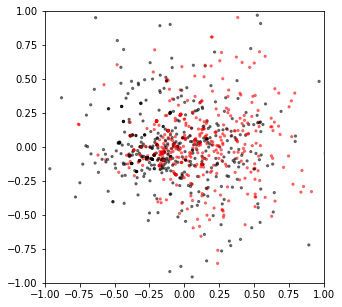

In [8]:
df_movies, vecs2D = plot_comedy_drama_embeddings(df, M.cpu().detach().numpy(), xrange=(-1,1), yrange=(-1.,1.))